In [66]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import os
import ptitprince as pt
from statistics import mean
import ipynb.fs.defs.functions as fct

# Load data

In [67]:
# Load IDs
with open('uniqueIDs.pkl', 'rb') as f:
    uniqueIDs = pickle.load(f)

In [68]:
# Load all counts
all_users_folder = 'data/all_users/'
all_counts = pd.read_pickle(all_users_folder + 'all_counts.pkl')

In [69]:
# Load all counts_R
all_counts_R = pd.read_pickle(all_users_folder + 'all_counts_R.pkl')

In [70]:
# Load all counts_B
all_counts_B = pd.read_pickle(all_users_folder + 'all_counts_B.pkl')

In [71]:
column_names = ['FB_-5', 'FB_-1', 'FB_1', 'FB_5', 
                'FB_no_-5', 'FB_no_-1', 'FB_no_1', 'FB_no_5']
all_counts[column_names].sum(axis=1)


0      28.0
1      28.0
2      28.0
3      28.0
4      28.0
       ... 
675    28.0
676    28.0
677    28.0
678    28.0
679    28.0
Length: 680, dtype: float64

In [72]:
# Check that there are 112 trials for each ID
N_trials = 112

for ID in uniqueIDs:
    
    N_trials_part = int(all_counts[all_counts['ID']==ID].drop(columns=['ID', 'Cue', 'R_-5', 'R_-1' , 'R_1', 'R_5']).values.sum())
    
    if N_trials_part != N_trials:
        print('Problem with ID: ' + str(ID))  
    
print('All checked')

All checked


# Functions

In [73]:
def reformat_for_excel(row_, col_name, ID):
    
    # Tranpose, add ID and change indices
    row_new = row_.T
    row_new.insert(0,'ID',ID)
    row_new = row_new.reset_index(drop=True).rename_axis(None, axis=1)
    
    # New column names (add the col_name extension)
    new_col_names = ['ID']
    
    for col in row_new.columns[1::]:
        new_col_names.append(col+col_name)
    
    row_new.columns=new_col_names
    
    return row_new

In [74]:
def plot_difference_hits(hit_dif_data, N_timepoints, ax):
    
    mean_ = hit_dif_data.mean()
    std_ = hit_dif_data.std()
    Npart = hit_dif_data.shape[0]

    x = np.arange(len(mean_))
    bar_width = 0.5

    ax.bar(x, mean_, width=bar_width, color = 'blue', alpha=.6)
    ax.errorbar(x, mean_, yerr=std_/(Npart-1), fmt="o", color="k")

    ax.axhline(y=0, color='k', linestyle='-')

    ax.set_xticks(x, ['Cue HP', 'Cue LP', 'Cue LR', 'Cue HR'], fontsize=12)
    
    ax.set_ylim(bottom=-0.4, top=0.1)
    ax.set_ylabel('Difference in hits (t' + str(N_timepoints) + '-t1)', fontsize=14)
    ax.set_title('Data split in ' + str(N_timepoints) + ' timepoints', fontsize=15)  

In [75]:
### Counts per timepoint and store in ALL COUNTS PER TIMEPOINT

def count_per_timepoint(window_size, uniqueIDs):
    
    '''
    Window size has to divide 112 (= Ntrials)
    '''

    all_counts_per_t = pd.DataFrame([])
    hit_counts_per_t = pd.DataFrame([])
    hit_perc_per_t = pd.DataFrame([])
    data_forexcel = pd.DataFrame([])

    for ID in uniqueIDs: 

        # Load df2_cf 
        user_folder = 'data/user_' + ID + '/'
        df2_cf = pd.read_pickle(user_folder + 'df2_cf.pkl')

        ### ALL COUNTS PER TIMEPOINT

        # Parameters
        N_trials = len(df2_cf)
        N_iter = int(N_trials/window_size)

        # Initialise a multi index frame (cues*fbs) to store the counts for each timepoint (=df_single_part)
        cues = set(df2_cf['Code'])
        fbs = set(df2_cf['FB Code'])
        timepoints = ['t'+ str(t+1) for t in range(N_iter)]
        my_index = pd.MultiIndex.from_product([cues,fbs], names=['Code','FB Code'])
        df_single_part = pd.DataFrame(index=my_index, columns=timepoints)

        # Fill in df_single_part
        for i in range(N_iter):

            timepoint = 't'+str(i+1)

            # Select trials
            window_start = i*window_size
            window = df2_cf[window_start:window_start+window_size]

            # Create df for this timepoint
            tmp_series = window.groupby(['Code', 'FB Code']).size()
            df_timepoint = tmp_series.to_frame(timepoint)

            # Fill in the overall dataframe
            df_single_part = df_single_part.combine_first(df_timepoint)

            # Count hits
            df_single_part_swap = df_single_part.swaplevel(0, 1, axis=0)
            hit_counts = df_single_part_swap.loc[['FB_-5','FB_-1','FB_1','FB_5']].groupby('Code').sum()

            # Compute percentage hits
            cue_counts = df_single_part_swap.groupby('Code').sum()
            hit_perc = hit_counts.div(cue_counts)
            hit_perc.replace([np.inf, -np.inf], np.nan, inplace=True) # division by zero if cue was not shown
        
        # If only one time point, save to excel
        if window_size == 112:
        
            # Reformat for excel
            tmp_forexcel = pd.concat([reformat_for_excel(hit_perc, '_hit_perc', ID), 
                             reformat_for_excel(hit_counts, '_hit_counts', ID),
                             reformat_for_excel(cue_counts, '_freq', ID)
                                     ], axis=1)

            data_forexcel = pd.concat([data_forexcel, tmp_forexcel])

        # Add ID columns
        df_single_part.insert(0,'ID',ID)
        hit_counts.insert(0,'ID',ID)
        hit_perc.insert(0,'ID',ID)
        
        # Concatenate all subjects
        all_counts_per_t = pd.concat([all_counts_per_t, df_single_part])
        hit_counts_per_t = pd.concat([hit_counts_per_t, hit_counts])
        hit_perc_per_t = pd.concat([hit_perc_per_t, hit_perc])

    trials_per_window = df_single_part.drop('ID', axis=1).sum()
    
    return hit_perc_per_t, timepoints, data_forexcel

# Step 1: Look at overall counts

In [76]:
all_counts.head()

,ID,Cue,FB_-1,FB_-5,FB_1,FB_5,FB_no_-1,FB_no_-5,FB_no_1,FB_no_5,R_-5,R_-1,R_1,R_5
0,001,Cue_HP,0.0,0.0,0.0,0.0,6.0,14.0,4.0,4.0,14.0,6.0,4.0,4.0
1,001,Cue_HR,2.0,3.0,1.0,5.0,2.0,1.0,5.0,9.0,4.0,4.0,6.0,14.0
2,001,Cue_LP,0.0,1.0,0.0,0.0,10.0,9.0,4.0,4.0,10.0,10.0,4.0,4.0
3,001,Cue_LR,2.0,3.0,7.0,5.0,2.0,1.0,3.0,5.0,4.0,4.0,10.0,10.0
4,003,Cue_HP,3.0,3.0,1.0,1.0,3.0,11.0,3.0,3.0,14.0,6.0,4.0,4.0


## Plot reward per cue (for each user)

In [77]:
for ID in uniqueIDs: 
    
    # Creates figure if does not already exist
    user_fig = 'data/user_' + ID + '/rewards_per_cue.png'
    isExist = os.path.exists(user_fig)
    if not isExist:
        
        print(ID)

        tmp_data = all_counts[all_counts['ID']==ID].set_index('Cue').reindex(['Cue_HP', 'Cue_LP', 'Cue_LR', 'Cue_HR'])

        # Plot obtained reward for each cue (irrespective of hit/miss)

        f = plt.figure(figsize=(8, 6), dpi=80)

        x = np.arange(len(tmp_data))
        bar_width = 0.15
        bar_distance = 0.03

        # Recieved reward for each cue 
        plt.bar(x-3/2*(bar_width+bar_distance), tmp_data['R_-5'], width=bar_width, color = 'red', alpha=0.6)
        plt.bar(x-1/2*(bar_width+bar_distance), tmp_data['R_-1'], width=bar_width, color = 'red', alpha=0.3)
        plt.bar(x+1/2*(bar_width+bar_distance), tmp_data['R_1'], width=bar_width, color = 'green', alpha=0.3)
        plt.bar(x+3/2*(bar_width+bar_distance), tmp_data['R_5'], width=bar_width, color = 'green', alpha=0.6)

        # Hatch = amount of Hits
        plt.bar(x-3/2*(bar_width+bar_distance), tmp_data['FB_-5'], width=bar_width, color = 'red', alpha=0, hatch='//////')
        plt.bar(x-1/2*(bar_width+bar_distance), tmp_data['FB_-1'], width=bar_width, color = 'red', alpha=0, hatch='//////')
        plt.bar(x+1/2*(bar_width+bar_distance), tmp_data['FB_1'], width=bar_width, color = 'green', alpha=0, hatch='//////')
        plt.bar(x+3/2*(bar_width+bar_distance), tmp_data['FB_5'], width=bar_width, color = 'green', alpha=0, hatch='//////')

        plt.xticks(x, tmp_data.index, fontsize=16)

        plt.ylabel('Frequency', fontsize=18)

        plt.title('Rewards and hits by Cue (User=' + ID + ')', fontsize=20)

        plt.legend(['R=-5', 'R=-1', 'R=1', 'R=5', 'Hits'], fontsize=12, title_fontsize=14)

        # Saves figures
        plt.savefig(user_fig)
        
        # So that they are not all displayed
        plt.close() 

## Plot reward per cue (average)

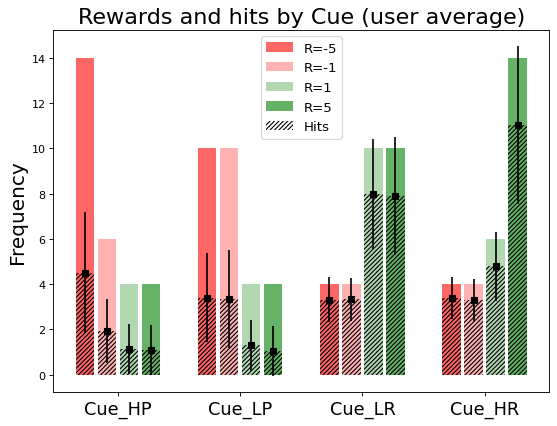

In [78]:
tmp_data = all_counts.groupby('Cue').mean().reindex(['Cue_HP', 'Cue_LP', 'Cue_LR', 'Cue_HR'])
tmp_data_std = all_counts.groupby('Cue').std().reindex(['Cue_HP', 'Cue_LP', 'Cue_LR', 'Cue_HR'])

f = plt.figure(figsize=(8, 6), dpi=80)

x = np.arange(len(tmp_data))
bar_width = 0.15
bar_distance = 0.03

# Recieved reward for each cue 
plt.bar(x-3/2*(bar_width+bar_distance), tmp_data['R_-5'], width=bar_width, color = 'red', alpha=0.6)
plt.bar(x-1/2*(bar_width+bar_distance), tmp_data['R_-1'], width=bar_width, color = 'red', alpha=0.3)
plt.bar(x+1/2*(bar_width+bar_distance), tmp_data['R_1'], width=bar_width, color = 'green', alpha=0.3)
plt.bar(x+3/2*(bar_width+bar_distance), tmp_data['R_5'], width=bar_width, color = 'green', alpha=0.6)

# Hatch = amount of Hits
plt.bar(x-3/2*(bar_width+bar_distance), tmp_data['FB_-5'], width=bar_width, color = 'red', alpha=0, hatch='//////')
plt.errorbar(x-3/2*(bar_width+bar_distance), tmp_data['FB_-5'], yerr=tmp_data_std['FB_-5'], color='k', marker='s',linestyle='') 
                
plt.bar(x-1/2*(bar_width+bar_distance), tmp_data['FB_-1'], width=bar_width, color = 'red', alpha=0, hatch='//////')
plt.errorbar(x-1/2*(bar_width+bar_distance), tmp_data['FB_-1'], yerr=tmp_data_std['FB_-1'], color='k', marker='s',linestyle='') 

plt.bar(x+1/2*(bar_width+bar_distance), tmp_data['FB_1'], width=bar_width, color = 'green', alpha=0, hatch='//////')
plt.errorbar(x+1/2*(bar_width+bar_distance), tmp_data['FB_1'], yerr=tmp_data_std['FB_1'], color='k', marker='s',linestyle='') 

plt.bar(x+3/2*(bar_width+bar_distance), tmp_data['FB_5'], width=bar_width, color = 'green', alpha=0, hatch='//////')
plt.errorbar(x+3/2*(bar_width+bar_distance), tmp_data['FB_5'], yerr=tmp_data_std['FB_5'], color='k', marker='s',linestyle='') 

plt.xticks(x, tmp_data.index, fontsize=16)
plt.ylabel('Frequency', fontsize=18)
plt.title('Rewards and hits by Cue (user average)', fontsize=20)
plt.legend(['R=-5', 'R=-1', 'R=1', 'R=5', 'Hits'], fontsize=12, title_fontsize=14)


# Saves it if does not already exist
all_users_fig = 'data/all_users/rewards_per_cue.png'
isExist = os.path.exists(all_users_fig)
if not isExist:
    plt.savefig('all_users_fig')

In [79]:
summ_stats = all_counts.drop('ID', axis=1).groupby("Cue").agg([np.mean, np.std])

# Step 2: Look at counts accross time

In [80]:
# Find all multiples of 112
N = 112
multiples = []
for n in range(1,N+1):
    if N % n == 0: # checks that divides 112 (=Ntrials)
        multiples.append(n)

print('Multiples of 112 =')
print(multiples)

# Select reasonable window sizes
window_sizes = multiples[2:-1]
print('\nReasonable window sizes =')
print(window_sizes)

Multiples of 112 =
[1, 2, 4, 7, 8, 14, 16, 28, 56, 112]

Reasonable window sizes =
[4, 7, 8, 14, 16, 28, 56]


## Saves hit percentage for different window sizes (average for all users)

In [92]:
# Creates user_folder if does not exist
all_users_folder = 'data/all_users/hit_perc_per_t/'
isExist = os.path.exists(all_users_folder)
if not isExist:
    os.makedirs(all_users_folder)

for window_size in window_sizes:
    # Creates pkl file for each window size if does not already exist
    all_users_file = all_users_folder + 'hit_perc_per_t_w' + str(window_size) + '.pkl'
    isExist = os.path.exists(all_users_file)
    if not isExist:
        print(window_size)

        # Get count per timepoint
        hit_perc_per_t, timepoints, data_forexcel = count_per_timepoint(window_size, uniqueIDs)
        
        # Save
        hit_perc_per_t.to_pickle(all_users_file)

4
7
8
14
16
28
56


## Plots hit percentage for different window sizes (average for all users)

In [82]:
# Creates fig folder in all_users if does not exist
all_users_folder_fig = 'data/all_users/hit_perc_per_t/fig/'
isExist = os.path.exists(all_users_folder_fig)
if not isExist:
    os.makedirs(all_users_folder_fig)
    
# Iterate over window sizes and create plots
for window_size in window_sizes:
    
    # Creates figure if does not already exist
    all_users_fig = all_users_folder_fig + 'hit_perc_per_t_w' + str(window_size) + '.png'
    isExist = os.path.exists(all_users_fig)
    if not isExist:
        print(window_size)

        # Load hit_perc_per_t (data per timepoit)
        all_users_folder = 'data/all_users/hit_perc_per_t/'
        hit_perc_per_t = pd.read_pickle(all_users_folder + 'hit_perc_per_t_w' + str(window_size) + '.pkl')
        hit_perc_per_t.drop('ID', axis=1, inplace=True)

        # Timepoints
        N_trials = 112
        N_iter = int(N_trials/window_size)
        timepoints = ['t'+ str(t+1) for t in range(N_iter)]

        # Compute stats
        stats_hits_perc_per_t = hit_perc_per_t.groupby('Code').agg(['mean', 'var']).T.swaplevel(axis=0)

        # Plot
        plt.figure(figsize=(12, 6), dpi=80)

        x = np.arange(len(timepoints))

        # Means
        plt.plot(x, stats_hits_perc_per_t.loc['mean']['Cue_HP'], 'o-', color='red', alpha=0.6)
        plt.plot(x, stats_hits_perc_per_t.loc['mean']['Cue_LP'], 'o-', color='red', alpha=0.3)
        plt.plot(x, stats_hits_perc_per_t.loc['mean']['Cue_LR'], 'o-', color='green', alpha=0.3)
        plt.plot(x, stats_hits_perc_per_t.loc['mean']['Cue_HR'], 'o-', color='green', alpha=0.6)

        # Variances
        plt.plot(x, stats_hits_perc_per_t.loc['mean']['Cue_HP']-
                 stats_hits_perc_per_t.loc['var']['Cue_HP'], ':', color='red', alpha=0.6)
        plt.plot(x, stats_hits_perc_per_t.loc['mean']['Cue_HP']+
                 stats_hits_perc_per_t.loc['var']['Cue_HP'], ':', color='red', alpha=0.6)

        plt.plot(x, stats_hits_perc_per_t.loc['mean']['Cue_LP']-
                 stats_hits_perc_per_t.loc['var']['Cue_LP'], ':', color='red', alpha=0.3)
        plt.plot(x, stats_hits_perc_per_t.loc['mean']['Cue_LP']+
                 stats_hits_perc_per_t.loc['var']['Cue_LP'], ':', color='red', alpha=0.3)

        plt.plot(x, stats_hits_perc_per_t.loc['mean']['Cue_LR']-
                 stats_hits_perc_per_t.loc['var']['Cue_LR'], ':', color='green', alpha=0.3)
        plt.plot(x, stats_hits_perc_per_t.loc['mean']['Cue_LR']+
                 stats_hits_perc_per_t.loc['var']['Cue_LR'], ':', color='green', alpha=0.3)

        plt.plot(x, stats_hits_perc_per_t.loc['mean']['Cue_HR']-
                 stats_hits_perc_per_t.loc['var']['Cue_HR'], ':', color='green', alpha=0.6)
        plt.plot(x, stats_hits_perc_per_t.loc['mean']['Cue_HR']+
                 stats_hits_perc_per_t.loc['var']['Cue_HR'], ':', color='green', alpha=0.6)


        plt.grid(axis='x', color='0.95')
        plt.legend(['Cue_HP', 'Cue_LP', 'Cue_LR', 'Cue_HR'], loc ='best')
        plt.title('Hits by cue by timepoint (window = ' + str(window_size) + ' trials)', fontsize=20)

        plt.xlabel("Timepoint", fontsize=16)
        plt.xticks(x,timepoints)

        plt.ylabel("Percentage of hits", fontsize=16)
        plt.ylim((0,1))
    
        # Save
        plt.savefig(all_users_fig)
        plt.close()

## Plots hit percentage for different window sizes (for each user)

In [93]:
for window_size in window_sizes:
    
    print('Window size = ' + str(window_size))
    
    # Load hit_perc_per_t (data per timepoit)
    all_users_folder = 'data/all_users/hit_perc_per_t/'
    hit_perc_per_t = pd.read_pickle(all_users_folder + 'hit_perc_per_t_w' + str(window_size) + '.pkl')

    # Timepoints
    N_trials = 112
    N_iter = int(N_trials/window_size)
    timepoints = ['t'+ str(t+1) for t in range(N_iter)]

    for ID in uniqueIDs: 
                
        # Creates fig folder if does not already exist
        user_folder = 'data/user_' + ID + '/hit_perc_per_t/'
        isExist = os.path.exists(user_folder)
        if not isExist:
            os.makedirs(user_folder)

        # Creates figure if does not already exist
        user_data = user_folder + 'hits_per_cue_per_timepoint_w' + str(window_size) + '.pkl'
        user_fig = user_folder + 'hits_per_cue_per_timepoint_w' + str(window_size) + '.png'
        isExist = os.path.exists(user_fig)
        if not isExist:
            
            print(ID)

            # Compute stats
            tmp_data = hit_perc_per_t[hit_perc_per_t['ID']==ID].drop(columns='ID')
            # Save to pickle
            tmp_data.to_pickle(user_data)

            # Plot
            plt.figure(figsize=(12, 6), dpi=80)

            x = np.arange(len(timepoints))

            # Means
            plt.plot(x, tmp_data.loc['Cue_HP'], 'o-', color='red', alpha=0.6)
            plt.plot(x, tmp_data.loc['Cue_LP'], 'o-', color='red', alpha=0.3)
            plt.plot(x, tmp_data.loc['Cue_LR'], 'o-', color='green', alpha=0.3)
            plt.plot(x, tmp_data.loc['Cue_HR'], 'o-', color='green', alpha=0.6)


            plt.grid(axis='x', color='0.95')
            plt.legend(['Cue_HP', 'Cue_LP', 'Cue_LR', 'Cue_HR'], loc ='best')
            plt.title('Hits by cue by timepoint (window=' + str(window_size) + ' trials, User=' + ID + ')', fontsize=20)

            plt.xlabel("Timepoint", fontsize=16)
            plt.xticks(x,timepoints)

            plt.ylabel("Percentage of hits", fontsize=16)
            plt.ylim((0,1))
            
            # Saves
            plt.savefig(user_fig)
            plt.close() 

Window size = 4
001
003
006
008
009
010
012
014
023
028
032
033
034
035
036
038
044
045
049
050
054
055
057
058
060
072
073
075
076
077
078
080
084
085
086
088
090
093
096
100
101
103
104
106
107
108
109
112
114
115
118
119
120
121
122
130
132
133
136
137
138
142
143
145
147
149
151
155
158
159
165
170
172
173
175
176
177
178
181
185
186
187
189
199
204
207
208
211
213
217
221
229
230
236
237
239
240
244
251
252
258
259
263
269
271
280
282
283
284
286
287
291
292
293
301
302
303
306
313
314
315
319
321
322
325
326
327
329
335
336
337
339
341
345
349
351
360
361
362
368
375
376
381
384
390
391
393
395
397
400
405
406
412
413
414
421
422
423
427
437
438
440
446
450
453
462
469
470
471
Window size = 7
001
003
006
008
009
010
012
014
023
028
032
033
034
035
036
038
044
045
049
050
054
055
057
058
060
072
073
075
076
077
078
080
084
085
086
088
090
093
096
100
101
103
104
106
107
108
109
112
114
115
118
119
120
121
122
130
132
133
136
137
138
142
143
145
147
149
151
155
158
159
165
170
172


# Save as Excel

In [29]:
hit_perc_per_t, timepoints, data_forexcel = count_per_timepoint(112, uniqueIDs)

data_forexcel = data_forexcel.loc[:,~data_forexcel.columns.duplicated()] # remove duplicate col names (=ID)

# Compute participant total reward
tmp_rew = all_counts.groupby('ID').sum()
tmp_rew['Rew_recieved'] = tmp_rew['FB_-1']*(-1) + tmp_rew['FB_-5']*(-5) + tmp_rew['FB_1']*(1) + tmp_rew['FB_5']*(5)

# Merge counts and reward
data_forexcel = data_forexcel.merge(tmp_rew, on='ID')

# Make percentage
data_forexcel['Cue_HP_hit_perc'] = data_forexcel['Cue_HP_hit_perc'] * 100
data_forexcel['Cue_HR_hit_perc'] = data_forexcel['Cue_HR_hit_perc'] * 100
data_forexcel['Cue_LP_hit_perc'] = data_forexcel['Cue_LP_hit_perc'] * 100
data_forexcel['Cue_LR_hit_perc'] = data_forexcel['Cue_LR_hit_perc'] * 100

# Save
data_forexcel.to_excel("data/all_users/counts.xlsx")
data_forexcel.to_pickle('data/all_users/data_forexcel.pkl')

In [30]:
data_forexcel.head()

,ID,Cue_HP_hit_perc,Cue_HR_hit_perc,Cue_LP_hit_perc,Cue_LR_hit_perc,Cue_HP_hit_counts,Cue_HR_hit_counts,Cue_LP_hit_counts,Cue_LR_hit_counts,Cue_HP_freq,...,FB_5,FB_no_-1,FB_no_-5,FB_no_1,FB_no_5,R_-5,R_-1,R_1,R_5,Rew_recieved
0,001,0.000000,39.285714,3.571429,60.714286,0.0,11.0,1.0,17.0,28.0,...,10.0,20.0,25.0,16.0,22.0,32.0,24.0,24.0,32.0,19.0
1,003,28.571429,60.714286,17.857143,100.000000,8.0,17.0,5.0,28.0,28.0,...,18.0,13.0,19.0,8.0,14.0,32.0,24.0,24.0,32.0,30.0
2,006,28.571429,75.000000,39.285714,92.857143,8.0,21.0,11.0,26.0,28.0,...,23.0,10.0,17.0,10.0,9.0,32.0,24.0,24.0,32.0,40.0
3,007,42.857143,85.714286,32.142857,96.428571,12.0,24.0,9.0,27.0,28.0,...,27.0,11.0,16.0,8.0,5.0,32.0,24.0,24.0,32.0,58.0
4,008,25.000000,100.000000,32.142857,92.857143,7.0,28.0,9.0,26.0,28.0,...,23.0,13.0,15.0,5.0,9.0,32.0,24.0,24.0,32.0,38.0


# Histograms of hits per cue

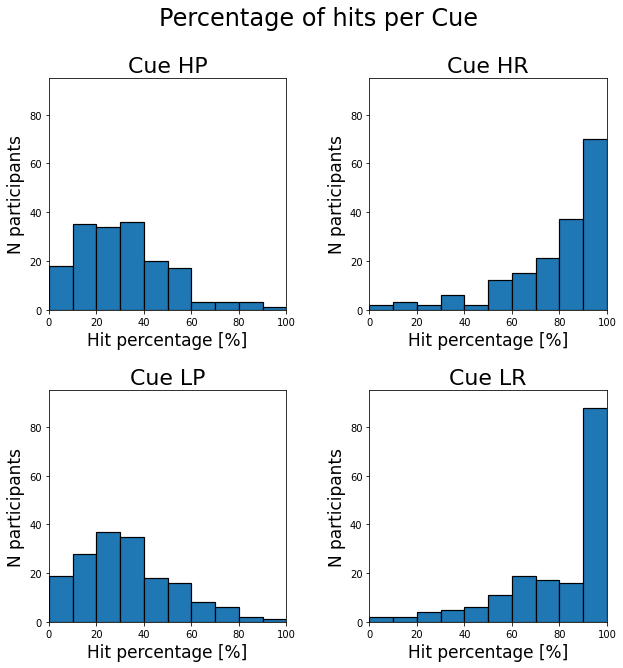

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace = 0.35, hspace = 0.35) # horizontal and vertical space between subplots

# Parameters
bins_list = np.arange(0, 110, 10)

# Plot
axs[0, 0].hist(data_forexcel['Cue_HP_hit_perc'], bins = bins_list, edgecolor='k', linewidth=1.2)
axs[0, 0].set_title('Cue HP', fontsize=22)

axs[0, 1].hist(data_forexcel['Cue_HR_hit_perc'], bins = bins_list, edgecolor='k', linewidth=1.2)
axs[0, 1].set_title('Cue HR', fontsize=22)

axs[1, 0].hist(data_forexcel['Cue_LP_hit_perc'], bins = bins_list, edgecolor='k', linewidth=1.2)
axs[1, 0].set_title('Cue LP', fontsize=22)

axs[1, 1].hist(data_forexcel['Cue_LR_hit_perc'], bins = bins_list, edgecolor='k', linewidth=1.2)
axs[1, 1].set_title('Cue LR', fontsize=22)

# Same properties for each subplot
for i, ax in enumerate(fig.axes):
        
    ax.set_ylabel('N participants', fontsize=17)
    ax.set_ylim(top=95)
    
    ax.set_xlabel('Hit percentage [%]', fontsize=17)
    ax.set_xlim(left=0, right=100)

    
fig.suptitle('Percentage of hits per Cue', fontsize=24)

user_folder = 'data/all_users/'

# Creates user folder if does not exist
isExist = os.path.exists(user_folder)
if not isExist:
    os.makedirs(user_folder)

plt.savefig(user_folder + 'hist_hits.png')

# Correlations with reward

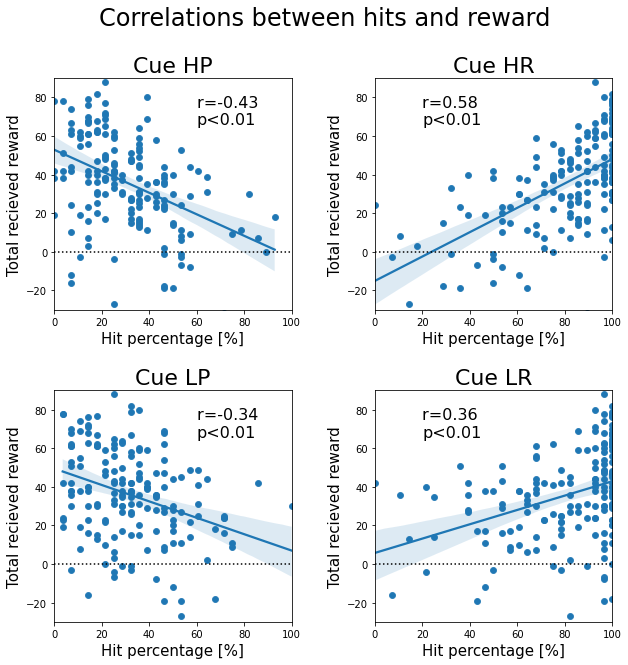

In [32]:

fig, axs = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace = 0.35, hspace = 0.35) # horizontal and vertical space between subplots

# Plot

# Properties
ylabel = 'Total recieved reward'
xlabel = 'Hit percentage [%]'
ylim = [-30, 90]
xlim = [0, 100]


# Correatios
fct.plot_correlation(title='Cue HP', x='Cue_HP_hit_perc', y='Rew_recieved', 
                     data=data_forexcel, ax=axs[0, 0], text_pos=[.6,.8], 
                     xlabel=xlabel, ylabel=ylabel, xlim=xlim, ylim=ylim)

fct.plot_correlation(title='Cue HR', x='Cue_HR_hit_perc', y='Rew_recieved', 
                     data=data_forexcel, ax=axs[0, 1], text_pos=[.2,.8], 
                     xlabel=xlabel, ylabel=ylabel, xlim=xlim, ylim=ylim)

fct.plot_correlation(title='Cue LP', x='Cue_LP_hit_perc', y='Rew_recieved', 
                     data=data_forexcel, ax=axs[1, 0], text_pos=[.6,.8], 
                     xlabel=xlabel, ylabel=ylabel, xlim=xlim, ylim=ylim)

fct.plot_correlation(title='Cue LR', x='Cue_LR_hit_perc', y='Rew_recieved', 
                     data=data_forexcel, ax=axs[1, 1], text_pos=[.2,.8], 
                     xlabel=xlabel, ylabel=ylabel, xlim=xlim, ylim=ylim)

fig.suptitle('Correlations between hits and reward', fontsize=24)

user_folder = 'data/all_users/'

# Creates user folder if does not exist
isExist = os.path.exists(user_folder)
if not isExist:
    os.makedirs(user_folder)

plt.savefig(user_folder + 'corr_rew.png')


<AxesSubplot:>

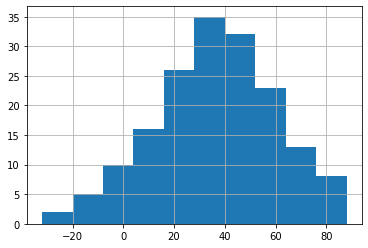

In [33]:
data_forexcel['Rew_recieved'].hist()

# Look at learning (difference in timepoints)

In [34]:
# Data split in 2 timepoints
N_timepoints = 2
N_trials = 112
hit_perc_per_t, timepoints, data_forexcel = count_per_timepoint(int(N_trials/N_timepoints), uniqueIDs)

# Compute difference between hits at t2 and hits at t1
hit_perc_per_t['t2_min_t1'] = hit_perc_per_t['t2'] - hit_perc_per_t['t1']
hit_dif_t2_t1 = hit_perc_per_t.drop(columns=timepoints)
hit_dif_t2_t1.reset_index(inplace=True)
hit_dif_t2_t1 = hit_dif_t2_t1.pivot(index='ID', columns='Code', values='t2_min_t1').rename_axis(None, axis=1).rename_axis(None, axis=0)
hit_dif_t2_t1 = hit_dif_t2_t1[['Cue_HP', 'Cue_LP', 'Cue_LR', 'Cue_HR']]

In [35]:
# Data split in 4 timepoints
N_timepoints = 4
N_trials = 112
hit_perc_per_t, timepoints, data_forexcel = count_per_timepoint(int(N_trials/N_timepoints), uniqueIDs)

# Compute difference between hits at t2 and hits at t1
hit_perc_per_t['t4_min_t1'] = hit_perc_per_t['t4'] - hit_perc_per_t['t1']
hit_dif_t4_t1 = hit_perc_per_t.drop(columns=timepoints)
hit_dif_t4_t1.reset_index(inplace=True)
hit_dif_t4_t1 = hit_dif_t4_t1.pivot(index='ID', columns='Code', values='t4_min_t1').rename_axis(None, axis=1).rename_axis(None, axis=0)
hit_dif_t4_t1 = hit_dif_t4_t1[['Cue_HP', 'Cue_LP', 'Cue_LR', 'Cue_HR']]

In [36]:
# Data split in 7 timepoints
N_timepoints = 7
N_trials = 112
hit_perc_per_t, timepoints, data_forexcel = count_per_timepoint(int(N_trials/N_timepoints), uniqueIDs)

# Compute difference between hits at t2 and hits at t1
hit_perc_per_t['t7_min_t1'] = hit_perc_per_t['t7'] - hit_perc_per_t['t1']
hit_dif_t7_t1 = hit_perc_per_t.drop(columns=timepoints)
hit_dif_t7_t1.reset_index(inplace=True)
hit_dif_t7_t1 = hit_dif_t7_t1.pivot(index='ID', columns='Code', values='t7_min_t1').rename_axis(None, axis=1).rename_axis(None, axis=0)
hit_dif_t7_t1 = hit_dif_t7_t1[['Cue_HP', 'Cue_LP', 'Cue_LR', 'Cue_HR']]

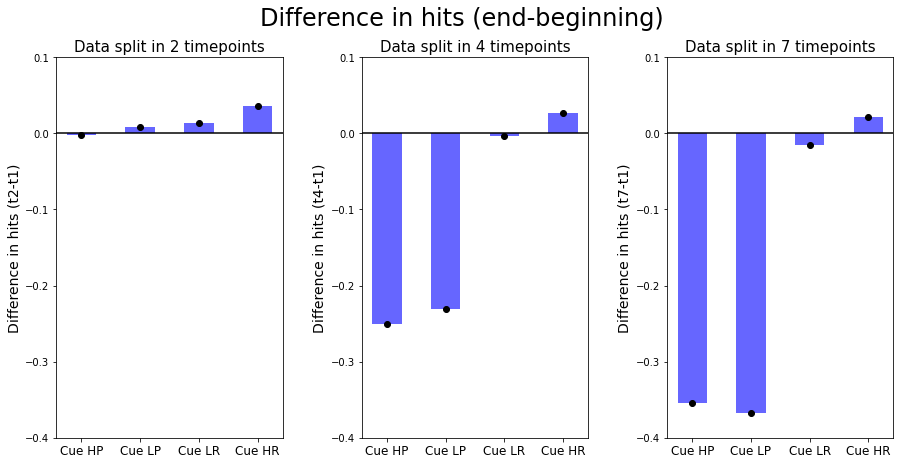

In [37]:
# Plots
fig, axs = plt.subplots(1, 3, figsize=(15,7))
plt.subplots_adjust(wspace = 0.35, hspace = 0.35) # horizontal and vertical space between subplots

plot_difference_hits(hit_dif_t2_t1, N_timepoints = 2, ax = axs[0])
plot_difference_hits(hit_dif_t4_t1, N_timepoints = 4, ax = axs[1])
plot_difference_hits(hit_dif_t7_t1, N_timepoints = 7, ax = axs[2])

fig.suptitle('Difference in hits (end-beginning)', fontsize=24)

user_folder = 'data/all_users/'

# Creates user folder if does not exist
isExist = os.path.exists(user_folder)
if not isExist:
    os.makedirs(user_folder)

plt.savefig(user_folder + 'diff_hits.png')

# Look for good participants

In [38]:
data_forexcel = pd.read_pickle('data/all_users/data_forexcel.pkl')

In [39]:
data_forexcel[
    
    ( data_forexcel['Cue_HP_hit_perc'] < 50  ) & 
    ( data_forexcel['Cue_HP_hit_perc'] > 5  ) & 
    
    ( data_forexcel['Cue_LP_hit_perc'] < 75  ) &
    ( data_forexcel['Cue_LP_hit_perc'] > 10  ) &
    
    ( data_forexcel['Cue_HR_hit_perc'] > 50  ) &
    ( data_forexcel['Cue_HR_hit_perc'] < 100 ) &
    
    ( data_forexcel['Cue_LR_hit_perc'] > 25  ) &
    ( data_forexcel['Cue_LR_hit_perc'] < 100 ) &
    
    ( data_forexcel['Rew_recieved']    > 55  )]

,ID,Cue_HP_hit_perc,Cue_HR_hit_perc,Cue_LP_hit_perc,Cue_LR_hit_perc,Cue_HP_hit_counts,Cue_HR_hit_counts,Cue_LP_hit_counts,Cue_LR_hit_counts,Cue_HP_freq,...,FB_5,FB_no_-1,FB_no_-5,FB_no_1,FB_no_5,R_-5,R_-1,R_1,R_5,Rew_recieved
3,007,42.857143,85.714286,32.142857,96.428571,12.0,24.0,9.0,27.0,28.0,...,27.0,11.0,16.0,8.0,5.0,32.0,24.0,24.0,32.0,58.0
7,012,21.428571,92.857143,25.000000,96.428571,6.0,26.0,7.0,27.0,28.0,...,27.0,11.0,22.0,8.0,5.0,32.0,24.0,24.0,32.0,88.0
13,034,21.428571,96.428571,14.285714,92.857143,6.0,27.0,4.0,26.0,28.0,...,25.0,14.0,20.0,8.0,7.0,32.0,24.0,24.0,32.0,71.0
23,057,10.714286,67.857143,39.285714,85.714286,3.0,19.0,11.0,24.0,28.0,...,20.0,12.0,23.0,8.0,12.0,32.0,24.0,24.0,32.0,59.0
29,076,10.714286,96.428571,25.000000,96.428571,3.0,27.0,7.0,27.0,28.0,...,23.0,12.0,20.0,7.0,9.0,32.0,24.0,24.0,32.0,60.0
38,093,10.714286,89.285714,46.428571,75.000000,3.0,25.0,13.0,21.0,28.0,...,23.0,14.0,20.0,7.0,9.0,32.0,24.0,24.0,32.0,62.0
61,138,7.142857,92.857143,14.285714,96.428571,2.0,26.0,4.0,27.0,28.0,...,22.0,15.0,21.0,7.0,10.0,32.0,24.0,24.0,32.0,63.0
99,251,35.714286,92.857143,35.714286,89.285714,10.0,26.0,10.0,25.0,28.0,...,25.0,7.0,19.0,8.0,7.0,32.0,24.0,24.0,32.0,59.0
102,259,39.285714,96.428571,10.714286,85.714286,11.0,27.0,3.0,24.0,28.0,...,25.0,12.0,20.0,8.0,7.0,32.0,24.0,24.0,32.0,69.0
114,293,25.000000,89.285714,35.714286,92.857143,7.0,25.0,10.0,26.0,28.0,...,26.0,13.0,17.0,8.0,6.0,32.0,24.0,24.0,32.0,60.0


In [40]:
all_counts_per_t = pd.DataFrame([])
hit_counts_per_t = pd.DataFrame([])
hit_perc_per_t = pd.DataFrame([])
data_forexcel = pd.DataFrame([])

uniqueIDs = ['007']
window_size = 28

for ID in uniqueIDs: 

    # Load df2_cf 
    user_folder = 'data/user_' + ID + '/'
    df2_cf = pd.read_pickle(user_folder + 'df2_cf.pkl')

    ### ALL COUNTS PER TIMEPOINT

    # Parameters
    N_trials = len(df2_cf)
    N_iter = int(N_trials/window_size)

    # Initialise a multi index frame (cues*fbs) to store the counts for each timepoint (=df_single_part)
    cues = set(df2_cf['Code'])
    fbs = set(df2_cf['FB Code'])
    timepoints = ['t'+ str(t+1) for t in range(N_iter)]
    my_index = pd.MultiIndex.from_product([cues,fbs], names=['Code','FB Code'])
    df_single_part = pd.DataFrame(index=my_index, columns=timepoints)

    # Fill in df_single_part
    for i in range(N_iter):

        timepoint = 't'+str(i+1)

        # Select trials
        window_start = i*window_size
        window = df2_cf[window_start:window_start+window_size]

        # Create df for this timepoint
        tmp_series = window.groupby(['Code', 'FB Code']).size()
        df_timepoint = tmp_series.to_frame(timepoint)

        # Fill in the overall dataframe
        df_single_part = df_single_part.combine_first(df_timepoint)

        # Count hits
        df_single_part_swap = df_single_part.swaplevel(0, 1, axis=0)
        hit_counts = df_single_part_swap.loc[['FB_-5','FB_-1','FB_1','FB_5']].groupby('Code').sum()

        # Compute percentage hits
        cue_counts = df_single_part_swap.groupby('Code').sum()
        hit_perc = hit_counts.div(cue_counts)
        hit_perc.replace([np.inf, -np.inf], np.nan, inplace=True) # division by zero if cue was not shown


## Running average but average hit/miss on each cue seperately

In [41]:
# Find all multiples of 28
N = 28
multiples = []
for n in range(1,N+1):
    if N % n == 0: # checks that divides 28 (=Ntrials)
        multiples.append(n)

print('Multiples of 28 =')
print(multiples)

Multiples of 28 =
[1, 2, 4, 7, 14, 28]


### For each participant

In [53]:
for ID in uniqueIDs: 

    # For loops
    #window_sizes = [4,7,14]
    window_sizes = [14]
    cues = ['HR', 'HP', 'LR', 'LP']

    # Creates user_folder if does not exist
    user_folder = 'data/user_' + ID 
    hit_miss_folder = user_folder + '/cue_hit_miss_perc/'
    isExist = os.path.exists(hit_miss_folder)
    if not isExist:
        os.makedirs(hit_miss_folder)

    # Load df2_cf 
    df2_cf = pd.read_pickle(user_folder + '/df2_cf.pkl')

    for window_size in window_sizes:

        for cue in cues:

            cue_file = hit_miss_folder + 'hit_miss_perc_' + cue + '_window_size_' + str(window_size) + '.pkl'
            
            # Parameters
            N_trials = len(cue_df2_cf)
            N_iter = int(N_trials/window_size)

            # Extract only trials with specific cue
            cue_string = 'Cue_' + cue
            cue_df2_cf = df2_cf[df2_cf['Code']==cue_string]
            cue_df2_cf.insert(1, 'CueTrial', range(1, N_trials + 1))

            # Initialise a multi index frame (type*fbs) to store the counts for each timepoint
            types = set(cue_df2_cf['Type'])
            timepoints = ['t'+ str(t+1) for t in range(N_iter)]
            df_single_part = pd.DataFrame(index=['hit', 'miss'], columns=timepoints)

            for i in range(N_iter):

                timepoint = 't'+str(i+1)

                # Select trials in window
                window_start = i*window_size
                window = cue_df2_cf[window_start:window_start+window_size]

                # Create df for this timepoint
                tmp_series = window.groupby(['Type']).size()
                df_timepoint = tmp_series.to_frame(timepoint)

                # Compute percentages
                counts = df_timepoint.sum()
                perc = df_timepoint.div(counts)

                # Fill in the overall dataframe
                df_single_part = df_single_part.combine_first(perc)
                
                
            # Replace nans with 0s
            df_single_part.replace(np.nan, 0, inplace=True)
            
            # Save
            df_single_part.to_pickle(cue_file)

In [55]:
cue_file

'data/user_007/cue_hit_miss_perc/hit_miss_perc_LP_window_size_14.pkl'

In [54]:
df_single_part

,t1,t2
hit,0.285714,0.357143
miss,0.714286,0.642857


# Hits per Cue

In [75]:
all_counts

,ID,Cue,FB_-1,FB_-5,FB_1,FB_5,FB_no_-1,FB_no_-5,FB_no_1,FB_no_5,R_-5,R_-1,R_1,R_5
0,001,Cue_HP,0.0,0.0,0.0,0.0,6.0,14.0,4.0,4.0,14.0,6.0,4.0,4.0
1,001,Cue_HR,2.0,3.0,1.0,5.0,2.0,1.0,5.0,9.0,4.0,4.0,6.0,14.0
2,001,Cue_LP,0.0,1.0,0.0,0.0,10.0,9.0,4.0,4.0,10.0,10.0,4.0,4.0
3,001,Cue_LR,2.0,3.0,7.0,5.0,2.0,1.0,3.0,5.0,4.0,4.0,10.0,10.0
4,003,Cue_HP,3.0,3.0,1.0,1.0,3.0,11.0,3.0,3.0,14.0,6.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,470,Cue_LR,4.0,4.0,10.0,10.0,0.0,0.0,0.0,0.0,4.0,4.0,10.0,10.0
676,471,Cue_HP,0.0,2.0,0.0,0.0,6.0,12.0,4.0,4.0,14.0,6.0,4.0,4.0
677,471,Cue_HR,4.0,3.0,3.0,7.0,0.0,1.0,3.0,7.0,4.0,4.0,6.0,14.0
678,471,Cue_LP,5.0,6.0,2.0,1.0,5.0,4.0,2.0,3.0,10.0,10.0,4.0,4.0


In [165]:
# Compute number of hits and make new column
all_counts['Hits'] = all_counts[['FB_-5', 'FB_-1', 'FB_1', 'FB_5']].sum(axis=1)

# Compute stats
tmp_data_mean = all_counts.groupby('Cue').mean().reindex(['Cue_HP', 'Cue_LP', 'Cue_LR', 'Cue_HR']);
tmp_data_std = all_counts.groupby('Cue').std().reindex(['Cue_HP', 'Cue_LP', 'Cue_LR', 'Cue_HR']);

In [167]:
tmp_data_mean

,FB_-1,FB_-5,FB_1,FB_5,FB_no_-1,FB_no_-5,FB_no_1,FB_no_5,R_-5,R_-1,R_1,R_5,Hits
Cue,,,,,,,,,,,,,
Cue_HP,1.929412,4.500000,1.129412,1.100000,4.070588,9.500000,2.870588,2.900000,14.0,6.0,4.0,4.0,8.658824
Cue_LP,3.347059,3.411765,1.305882,1.058824,6.652941,6.588235,2.694118,2.941176,10.0,10.0,4.0,4.0,9.123529
Cue_LR,3.329412,3.311765,8.000000,7.894118,0.670588,0.688235,2.000000,2.105882,4.0,4.0,10.0,10.0,22.535294
Cue_HR,3.311765,3.382353,4.794118,11.017647,0.688235,0.617647,1.205882,2.982353,4.0,4.0,6.0,14.0,22.505882


In [1]:
f, axs = plt.subplots(1, 1, figsize=(7, 5), dpi=80);
pal = sns.color_palette(n_colors=1)

x = np.arange(len(tmp_data_mean))

# Figure 2: reward recieved for each cue = amount of Hits
h1=axs.bar(x[0], tmp_data_mean.loc['Cue_HP']['Hits'], width=bar_width, color = pal, alpha=0.5);
e1=axs.errorbar(x[0], tmp_data_mean.loc['Cue_HP']['Hits'], yerr=tmp_data_std.loc['Cue_HP']['Hits'], color='k', marker='s',linestyle='');

h2=plt.bar(x[1], tmp_data_mean.loc['Cue_LP']['Hits'], width=bar_width, color = pal, alpha=0.5);
e2=plt.errorbar(x[1], tmp_data_mean.loc['Cue_LP']['Hits'], yerr=tmp_data_std.loc['Cue_LP']['Hits'], color='k', marker='s',linestyle=''); 

h3=plt.bar(x[2], tmp_data_mean.loc['Cue_LR']['Hits'], width=bar_width, color = pal, alpha=0.5);
e3=plt.errorbar(x[2], tmp_data_mean.loc['Cue_LR']['Hits'], yerr=tmp_data_std.loc['Cue_LR']['Hits'], color='k', marker='s',linestyle='');

h4=plt.bar(x[3], tmp_data_mean.loc['Cue_HR']['Hits'], width=bar_width, color = pal, alpha=0.5);
e4=plt.errorbar(x[3], tmp_data_mean.loc['Cue_HR']['Hits'], yerr=tmp_data_std.loc['Cue_HR']['Hits'], color='k', marker='s',linestyle=''); 

pt.half_violinplot(ax=axs, x="Cue", y="Hits", data=all_counts, order = ['Cue_HP', 'Cue_LP', 'Cue_LR', 'Cue_HR'], palette = pal, bw = .2, cut = 0., scale = "area", width = .6, inner = None, orient = 'v')
sns.stripplot(ax=axs, x="Cue", y="Hits", data=all_counts, order = ['Cue_HP', 'Cue_LP', 'Cue_LR', 'Cue_HR'], palette = pal, edgecolor = "white", size = 4, jitter = 1, zorder = 0, orient = 'v', alpha=.4)

axs.set_xlabel('');
axs.set_xticks(x, tmp_data_mean.index, fontsize=14);
axs.set_ylabel('Frequency', fontsize=16);
axs.set_title('Mean Hit freq by Cue', fontsize=18);

plt.show();

NameError: name 'plt' is not defined

In [ ]:
all_counts

# Hits per run

In [372]:
# Compute number of hits and make new column
all_counts_R['Hits'] = all_counts_R[['FB_-5', 'FB_-1', 'FB_1', 'FB_5']].sum(axis=1)

# Compute stats
tmp_data_mean = all_counts_R.groupby(['Cue', 'Run']).mean();
tmp_data_std = all_counts_R.groupby(['Cue', 'Run']).std();

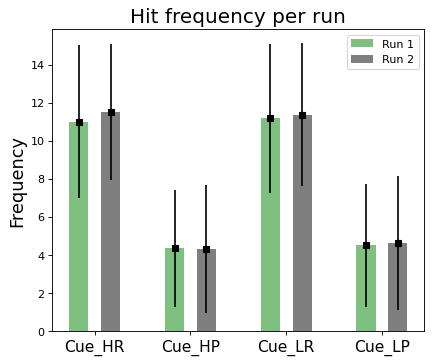

In [373]:
f, axs = plt.subplots(1, 1, figsize=(6, 5), dpi=80);
pal = sns.color_palette(n_colors=1)

bar_width = 0.6
n_runs = 2
x = np.arange(len(tmp_data_mean)*n_runs)
x_spaced = list(np.delete(x, np.arange(0, x.size, n_runs+1))) # remove every 3rd elemet (space between runs)

group_by = n_runs
x_grouped = [x_spaced[i:i + group_by] for i in range(0, len(x_spaced), group_by)]

x_ticks = [sum(grp)/len(grp) for grp in x_grouped]

cues = set([cue for cue, run in tmp_data_mean.index])
runs = set([run for cue, run in tmp_data_mean.index])

for i, cue in enumerate(cues):
    l = axs.bar(x_grouped[i], tmp_data_mean.loc[cue]['Hits'], width=bar_width, color = ['g', 'k'], alpha=0.5);
    axs.errorbar(x_grouped[i], tmp_data_mean.loc[cue]['Hits'], yerr=tmp_data_std.loc[cue]['Hits'], color='k', marker='s',linestyle='');

axs.legend(l, ['Run ' + str(run) for run in runs])
axs.set_xticks(x_ticks[0:4], set(cues), fontsize=14);
axs.set_title('Hit frequency per run', fontsize=18);
axs.set_ylabel('Frequency', fontsize=16);

# Hits per block

In [392]:
# Compute number of hits and make new column
all_counts_B['Hits'] = all_counts_B[['FB_-5', 'FB_-1', 'FB_1', 'FB_5']].sum(axis=1)

# Compute stats
tmp_data_mean = all_counts_B.groupby(['Cue', 'Block']).mean();
tmp_data_std = all_counts_B.groupby(['Cue', 'Block']).std();

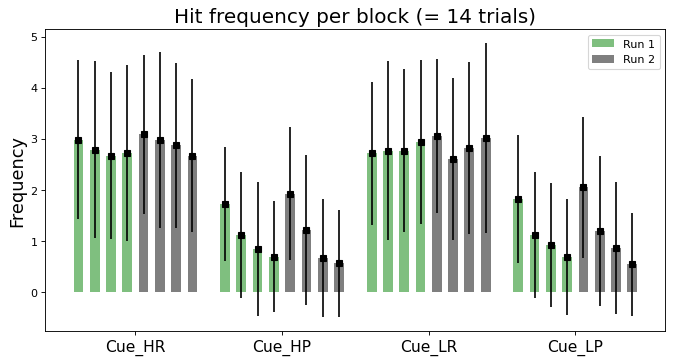

In [393]:
f, axs = plt.subplots(1, 1, figsize=(10, 5), dpi=80);
pal = sns.color_palette(n_colors=1)

bar_width = 0.6
n_blocks = 8 
n_blocks_per_run = int(n_blocks/2)
x = np.arange(len(tmp_data_mean)*n_blocks)
x_spaced = list(np.delete(x, np.arange(0, x.size, n_blocks+1))) # remove every xth elemet (space between runs)
block_size = 112/n_blocks

group_by = n_blocks
x_grouped = [x_spaced[i:i + group_by] for i in range(0, len(x_spaced), group_by)]

x_ticks = [sum(grp)/len(grp) for grp in x_grouped]

cues = set([cue for cue, block in tmp_data_mean.index])
blocks = set([block for cue, block in tmp_data_mean.index])

for i, cue in enumerate(cues):
    l = axs.bar(x_grouped[i], tmp_data_mean.loc[cue]['Hits'], color = list(n_blocks_per_run*'g'+n_blocks_per_run*'k'), width=bar_width, alpha=0.5);
    axs.errorbar(x_grouped[i], tmp_data_mean.loc[cue]['Hits'], yerr=tmp_data_std.loc[cue]['Hits'], color='k', marker='s',linestyle='');

axs.set_xticks(x_ticks[0:4], set(cues), fontsize=14);
axs.set_title('Hit frequency per block (= ' + str(int(block_size)) + ' trials)', fontsize=18);
axs.set_ylabel('Frequency', fontsize=16);
axs.legend([l[0], l[n_blocks_per_run]], ['Run ' + str(run) for run in runs])

plt.show()

In [226]:
# TODO
# Then add the interesting one to r markdown
# can also simplify the plot above this one to enumeraet the indices (change also in markdown)
# If see something, add to model

[0, 1]